In [4]:
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from udls.generated import AudioExample

In [5]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, encoding_dim):
        super(AE, self).__init__()
        self.encoding_dims = encoding_dim
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
class VAE(AE):
    
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(VAE, self).__init__(encoder, decoder, encoding_dims)
        self.latent_dims = latent_dims
        self.mu = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims))
        self.sigma = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus())
        
    def encode(self, x):
        
        x = self.encoder(x)

        mu = self.mu(x)
        sigma = self.sigma(x)

        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde.reshape(-1, 1, 28, 28), kl_div
    
    def latent(self, z_params):
        
        normal = distrib.Normal(loc=0., scale=1.)
        mu, sigma = z_params
        kl_div = torch.sum(1 + torch.log(sigma**2) - mu**2 - 2*(sigma**2))/2
        z = mu + sigma * normal.sample(sigma.shape)
    
        return z, kl_div

In [7]:
def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
          nn.Flatten(),
          nn.Linear(nin, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
    )
    # Decoder network
    decoder = nn.Sequential(
          nn.Linear(n_latent, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, nin * n_classes), nn.Sigmoid()
    )
    return encoder, decoder

In [8]:
# Reconstruction criterion
recons_criterion = torch.nn.MSELoss(reduction='sum')

def compute_loss(model, x, beta):
        
    y, kl_div = model(x)

    recons_loss = recons_criterion(y,x)

    full_loss = recons_loss - beta * kl_div
        
    return full_loss

def train_step(model, x, optimizer, beta):
    # Compute the loss.
    loss = compute_loss(model, x, beta)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    return loss

In [9]:
dataset_dir = './data'
# Going to use 80%/20% split for train/valid
valid_ratio = 0.2
# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.MNIST(root=dataset_dir, train=True, transform=torchvision.transforms.ToTensor(), download=True)
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
# Load the test set
test_dataset = torchvision.datasets.MNIST(root=dataset_dir, transform=torchvision.transforms.ToTensor(),train=False)
# Prepare 
num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

100%|██████████| 9912422/9912422 [00:00<00:00, 22658656.25it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 19864823.52it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 15558810.79it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 3326441.20it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [35]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 3
# Compute input dimensionality
imgs_test, _ = next(iter(test_loader))
nin = imgs_test.shape[2] * imgs_test.shape[3]
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)
# Construct the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [36]:
def beta_warmup(start, stop, epochs):
    betas = torch.zeros(epochs)
    for i in range(start, stop):
        betas[i] = 1 - (stop-i)/(stop-start)
    betas[stop:] = 1
    betas += 0.1
    return(betas)

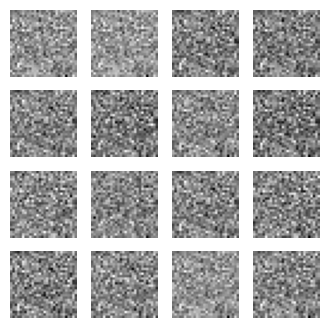

Epoch: 10, Test set ELBO: tensor([1212688.3750], grad_fn=<AddBackward0>)
Epoch: 20, Test set ELBO: tensor([1436110.8750], grad_fn=<AddBackward0>)
Epoch: 30, Test set ELBO: tensor([1527851.5000], grad_fn=<AddBackward0>)
Epoch: 40, Test set ELBO: tensor([1508063.], grad_fn=<AddBackward0>)


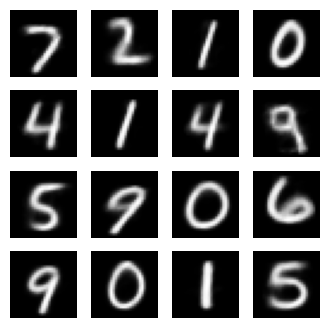

IndexError: index 50 is out of bounds for dimension 0 with size 50

In [38]:
def generate_and_save_images(model, epoch, test_sample):
    predictions, _ = model(test_sample)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, 0, :, :].detach(), cmap='gray')
        plt.axis('off')
    # Tight_layout minimizes the overlap between 2 sub-plots
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

epochs = 50
test_sample = imgs_test[0:16, :, :, :]
betas = beta_warmup(10,25, epochs)
for epoch in range(1, epochs + 1):
    if (epoch == 1 or epoch == epochs):
        generate_and_save_images(model, epoch, test_sample)
    full_loss = torch.Tensor([0])
    # Forward pass: compute predicted y by passing x to the model.
    for i, (x, _) in enumerate(train_loader):
        full_loss += train_step(model, x, optimizer, beta = betas[epoch])
    #for i, (x, _) in enumerate(valid_loader):
    #    train_step(model, x, optimizer)
    if (epoch % 10 == 0):
        print('Epoch: {}, Test set ELBO: {}'.format(epoch, full_loss))